In [4]:
import pandas as pd
from pandas import HDFStore

import numpy as np
from numpy import array
import h5py

In [8]:

from utils import read_big_pickle
# file is larger than 2GB, use pickle to read in by chunks
file_paths = ["data/sequence_train.pkl", "data/sequence_val.pkl", "data/sequence_test.pkl"]

genes_train = read_big_pickle(file_paths[0])
genes_val = read_big_pickle(file_paths[1])
genes_test = read_big_pickle(file_paths[2])
        

In [9]:
experiment_tag = "012"

In [17]:
input_train = np.stack(genes_train["seq"], axis=0)
input_train.shape

(36390, 2000, 4)

In [19]:
input_val = np.stack(genes_val["seq"], axis=0)
input_val.shape

(2599, 2000, 4)

In [73]:
cell_type = "E012"

output_train = np.array(genes_train[cell_type])
output_train.shape

(36390,)

In [74]:
output_val = np.array(genes_val[cell_type])
output_val.shape

(2599,)

In [75]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten

import tensorflow as tf
from sklearn.metrics import roc_auc_score

In [76]:
# Fix random seeds
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [77]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6539401078479510272
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 149618688
locality {
  bus_id: 1
}
incarnation: 3023471766598637098
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:02:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 143589376
locality {
  bus_id: 1
}
incarnation: 7319554630323468375
physical_device_desc: "device: 1, name: GeForce GTX 1060 3GB, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


In [78]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, input_shape=(2000, 4), activation="relu", name="Conv1"))
model.add(Conv1D(filters=64, kernel_size=10, activation="relu", name="Conv2"))
model.add(MaxPooling1D(pool_size=5))
# model.add(Dropout(0.5))

model.add(Conv1D(filters=128, kernel_size=10, activation="relu", name="Conv3"))
model.add(Conv1D(filters=128, kernel_size=10, activation="relu", name="Conv4"))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=10, activation="relu", name="Conv5"))
model.add(Conv1D(filters=256, kernel_size=10, activation="relu", name="Conv6"))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=10, activation="relu", name="Conv7"))
model.add(Conv1D(filters=256, kernel_size=10, activation="relu", name="Conv8"))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))



model.add(Flatten(name="Flatten1"))

model.add(Dense(625, activation='relu', name='Dense1'))
model.add(Dense(625, activation='relu', name='Dense2'))
model.add(Dense(125, activation='relu', name='Dense3'))
model.add(Dense(1, activation="linear", name='Dense4'))





In [79]:
from keras import Model
from keras.utils import multi_gpu_model


class ModelMGPU(Model):
    def __init__(self, ser_model, gpus):
        pmodel = multi_gpu_model(ser_model, gpus)
        self.__dict__.update(pmodel.__dict__)
        self._smodel = ser_model
    
    def __getattribute__(self, attrname):
        # return Model.__getattribute__(self, attrname)
        if 'load' in attrname or 'save' in attrname:
            return getattr(self._smodel, attrname)
        
        return super(ModelMGPU, self).__getattribute__(attrname)




parallel_model = ModelMGPU(model, gpus = 2)
parallel_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mae'])

print(model.summary())
print(parallel_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv1D)               (None, 1991, 64)          2624      
_________________________________________________________________
Conv2 (Conv1D)               (None, 1982, 64)          41024     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 396, 64)           0         
_________________________________________________________________
Conv3 (Conv1D)               (None, 387, 128)          82048     
_________________________________________________________________
Conv4 (Conv1D)               (None, 378, 128)          163968    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 126, 128)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 126, 128)          0         
__________

In [80]:
from keras.callbacks import ModelCheckpoint

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath=("models/experiments_" + experiment_tag +".hdf5"), verbose=1, save_best_only=True)

In [81]:
history = []

In [82]:

history.append(
    parallel_model.fit(input_train, output_train, validation_data=(input_val, output_val), initial_epoch=0 ,epochs=30, batch_size=512, shuffle=True ,validation_split=0.2, callbacks=[checkpointer]))

Train on 36390 samples, validate on 2599 samples
Epoch 1/30
36390/36390 [==============================] - 38s 1ms/step - loss: 1.4849 - mean_absolute_error: 9.8373 - val_loss: 0.9708 - val_mean_absolute_error: 7.1116

Epoch 00001: val_loss improved from inf to 0.97076, saving model to models/experiments_003.hdf5
Epoch 2/30
36390/36390 [==============================] - 38s 1ms/step - loss: 1.1733 - mean_absolute_error: 9.4311 - val_loss: 0.9113 - val_mean_absolute_error: 6.9282

Epoch 00002: val_loss improved from 0.97076 to 0.91131, saving model to models/experiments_003.hdf5
Epoch 3/30
36390/36390 [==============================] - 38s 1ms/step - loss: 1.1096 - mean_absolute_error: 9.3176 - val_loss: 0.8807 - val_mean_absolute_error: 6.8640

Epoch 00003: val_loss improved from 0.91131 to 0.88066, saving model to models/experiments_003.hdf5
Epoch 4/30
36390/36390 [==============================] - 38s 1ms/step - loss: 1.0631 - mean_absolute_error: 9.2163 - val_loss: 1.0451 - val_mean

In [83]:
import matplotlib.pyplot as plt

def plot_histories(histories):
    plt.clf()
    train_mae = []
    val_mae = []
    
    loss = []
    val_loss= []
    for history in histories:
        for error in history.history['mean_absolute_error']:
            train_mae.append(error)
        for error in history.history['val_mean_absolute_error']:
            val_mae.append(error)
        for error in history.history['loss']:
            loss.append(error)
        for error in history.history['val_loss']:
            val_loss.append(error)
    epochs = range(1, len(train_mae) + 1)

    plt.plot(epochs, train_mae, 'b', label='Training mae')
    plt.plot(epochs, val_mae, 'r', label='val mae')
    plt.title('mean absolute error')
    plt.legend()
    plt.show()
    
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='val loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


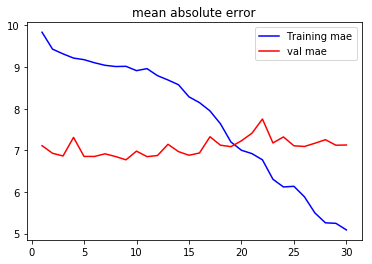

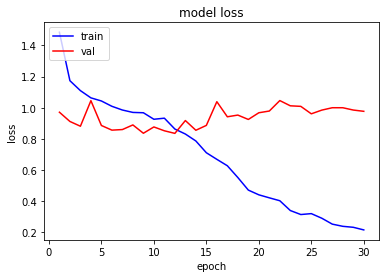

In [84]:

# plot traning history  
plot_histories(history)

In [96]:
input_test = np.stack(genes_test["seq"], axis=0)
input_test.shape

(3449, 2000, 4)

In [97]:
output_test = np.array(genes_test[cell_type])
output_test.shape

(3449,)

## Model prediction

In [98]:
from keras.models import load_model

best_model = load_model("models/experiments_" + experiment_tag + ".hdf5")

pred = best_model.predict(input_test)
exp = output_test

pred_log = np.log(pred+1)
exp_log = np.log(exp+1)

/home/qihzhong/anaconda3/envs/bio-ai/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


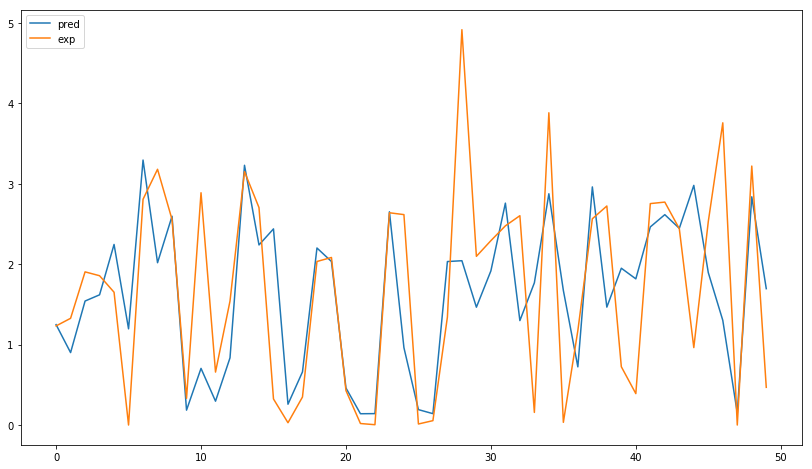

In [99]:
plt.figure(figsize=(14, 8))
plt.plot(pred_log[:50], label='pred')
plt.plot(exp_log[:50], label='actual exp')
plt.legend(['pred', 'exp'], loc='upper left')
plt.show()

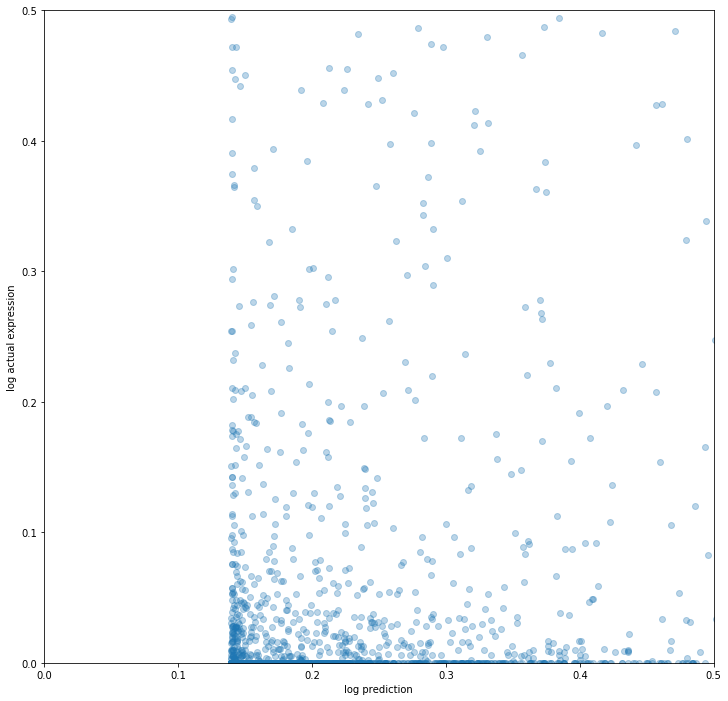

In [114]:
plt.figure(figsize=(12, 12))
plt.xlabel("log prediction")
plt.ylabel("log actual expression")
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.scatter(pred_log, exp_log, alpha=0.3)
plt.show()


**Pearson Correlation**

In [102]:
# np.corrcoef(pred_log, exp_log.reshape((3449,1)), rowvar=False)[0,1]


from scipy import stats
pearson_coef, p_value = stats.pearsonr(pred_log, exp_log.reshape((3449,1)))
print("pearson coef = " , pearson_coef)
print("p value = ", p_value)

pearson coef =  [0.68264553]
p value =  [0.]


**Random results based on means and standard deviation**

pearson coef =  -0.01027588797511337
p value =  0.5463214724028294


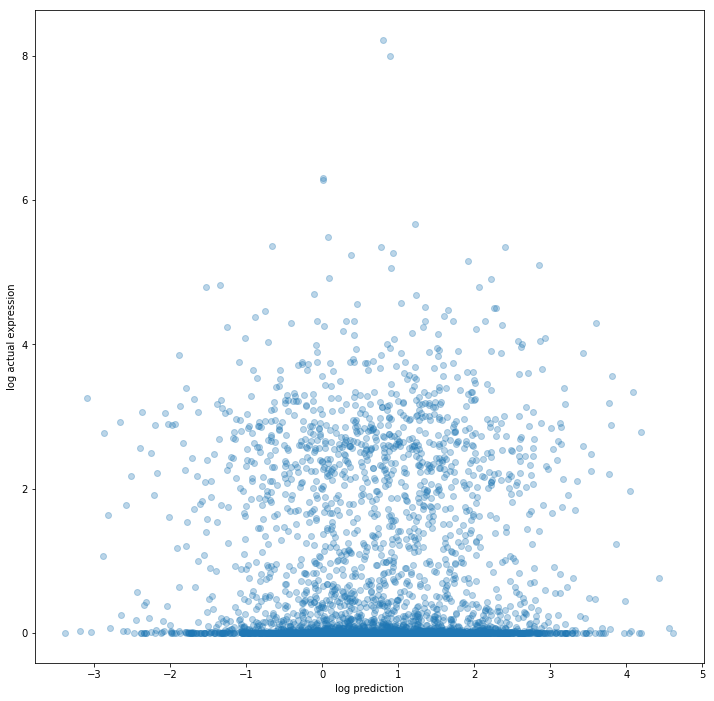

In [103]:
random_results = np.random.normal(exp_log.mean(), exp_log.std(), 3449)

pearson_coef, p_value = stats.pearsonr(random_results, exp_log)
print("pearson coef = " , pearson_coef)
print("p value = ", p_value)

plt.figure(figsize=(12, 12))
plt.xlabel("log prediction")
plt.ylabel("log actual expression")
plt.scatter(random_results, exp_log, alpha=0.3)
plt.show()

In [104]:
np.corrcoef(random_results, exp_log.reshape((3449,1)), rowvar=False)[0,1]

-0.010275887975113362

**Random shuffle of expressions**

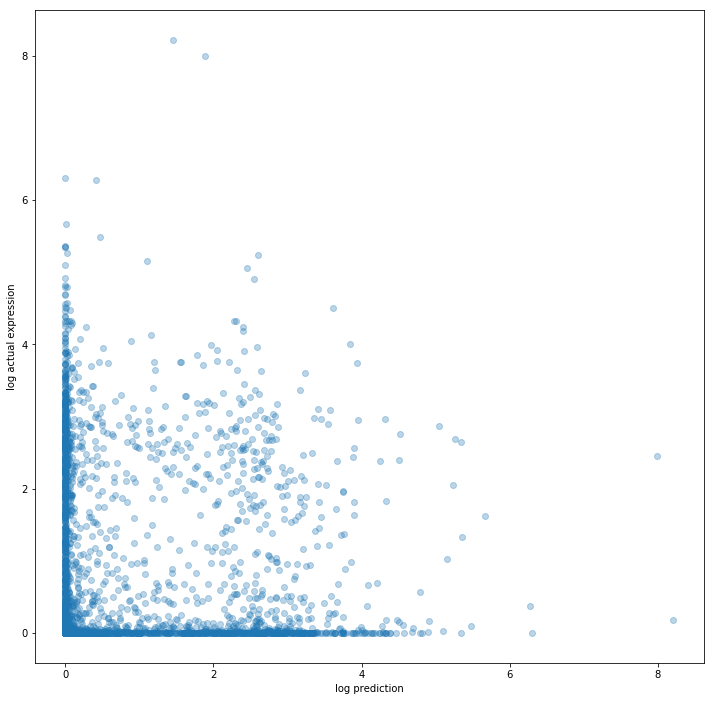

In [105]:
from sklearn.utils import shuffle

exp_shuffled = shuffle(exp_log)

plt.figure(figsize=(12, 12))
plt.xlabel("log prediction")
plt.ylabel("log actual expression")
plt.scatter(exp_shuffled, exp_log, alpha=0.3)
plt.show()

In [106]:
pearson_coef, p_value = stats.pearsonr(exp_shuffled.reshape(3449,1), exp_log.reshape((3449,1)))
print("pearson coef = " , pearson_coef)
print("p value = ", p_value)

pearson coef =  [-0.00445647]
p value =  [0.79360929]


In [107]:
import pickle

histories = []
for h in history:
    histories.append(h.history)

with open("models/history_" + experiment_tag + ".pkl", 'wb') as f_out:
    pickle.dump(histories ,f_out)

    
# read from pickled history
h = pickle.load(open("models/history_" + experiment_tag + ".pkl", "rb"))